**Setup & Configuration**

In [2]:
!pip install -q transformers torch

import torch
import json
import os
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import zipfile
import shutil

print("✅ Libraries imported!")
print(f"🔧 GPU Available: {torch.cuda.is_available()}")

✅ Libraries imported!
🔧 GPU Available: True


**Load Models**

In [3]:
# Check uploaded files
print("📂 Files in /content/ directory:")
for f in os.listdir('/content/'):
    if 'emotion' in f.lower() or 'crisis' in f.lower():
        print(f"   ✅ {f}")

# Find uploaded files
emotion_zip = None
crisis_file = None

for f in os.listdir('/content/'):
    if 'emotion' in f.lower() and (f.endswith('.zip') or f.endswith('.rar')):
        emotion_zip = f'/content/{f}'
    if 'crisis' in f.lower() and (f.endswith('.zip') or f.endswith('.rar')):
        crisis_file = f'/content/{f}'

print(f"\n✅ Found Emotion Model: {emotion_zip}")
print(f"✅ Found Crisis Model: {crisis_file}")

# Create directories & extract
os.makedirs("./emotion_model", exist_ok=True)
os.makedirs("./crisis_model", exist_ok=True)

if emotion_zip and emotion_zip.endswith('.zip'):
    with zipfile.ZipFile(emotion_zip, 'r') as zip_ref:
        zip_ref.extractall("./emotion_model")
    print("✅ Emotion model extracted!")

if crisis_file:
    if crisis_file.endswith('.zip'):
        with zipfile.ZipFile(crisis_file, 'r') as zip_ref:
            zip_ref.extractall("./crisis_model")
        print("✅ Crisis model extracted!")
    elif crisis_file.endswith('.rar'):
        !apt-get install -qq unrar
        !unrar x -o+ "{crisis_file}" ./crisis_model/
        print("✅ Crisis model extracted!")

# Find model path helper
def find_model_path(base_path):
    if os.path.exists(os.path.join(base_path, "config.json")):
        return base_path
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and os.path.exists(os.path.join(item_path, "config.json")):
            return item_path
    return base_path

# Load Emotion Model
emotion_model_path = find_model_path("./emotion_model")
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_path)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_path)
emotion_model.eval()
print(f"✅ Emotion model loaded from: {emotion_model_path}")

# Load Crisis Model
crisis_model_path = find_model_path("./crisis_model")
crisis_tokenizer = AutoTokenizer.from_pretrained(crisis_model_path)
crisis_model = AutoModelForSequenceClassification.from_pretrained(crisis_model_path)
crisis_model.eval()
print(f"✅ Crisis model loaded from: {crisis_model_path}")

# Get correct label mapping from config
with open(os.path.join(emotion_model_path, "config.json"), 'r') as f:
    config = json.load(f)

EMOTION_LABELS = {int(k): v for k, v in config["id2label"].items()}
CRISIS_LABELS = {0: 'normal', 1: 'high_distress'}

print(f"\n📊 Emotion Labels: {list(EMOTION_LABELS.values())}")
print(f"🚨 Crisis Labels: {list(CRISIS_LABELS.values())}")

📂 Files in /content/ directory:
   ✅ Crisis Model.rar
   ✅ emotion_model.zip

✅ Found Emotion Model: /content/emotion_model.zip
✅ Found Crisis Model: /content/Crisis Model.rar
✅ Emotion model extracted!

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Crisis Model.rar

Creating    ./crisis_model/Crisis Model                               OK
Extracting  ./crisis_model/Crisis Model/config.json                        0%  OK 
Extracting  ./crisis_model/Crisis Model/Crisis_dataset.ipynb               0%  OK 
Extracting  ./crisis_model/Crisis Model/Crisis_Model_Report.txt            0%  OK 
Extracting  ./crisis_model/Crisis Model/model.safetensors                  1%  3%  5%  6%  8% 10% 11% 13% 15% 16% 18% 20% 21% 23% 25% 27% 28% 30% 32% 33% 35% 37% 38% 40% 42% 43% 45% 47% 48% 50% 52% 54%

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

✅ Emotion model loaded from: ./emotion_model


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

✅ Crisis model loaded from: ./crisis_model/Crisis Model

📊 Emotion Labels: ['surprise', 'joy', 'neutral', 'sadness', 'anger', 'fear']
🚨 Crisis Labels: ['normal', 'high_distress']


**Prediction Functions**

In [4]:
def predict_emotion(text):
    """Predict emotion from text"""
    inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)

    with torch.no_grad():
        outputs = emotion_model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)[0]
    predicted_id = torch.argmax(probs).item()
    confidence = probs[predicted_id].item()

    return {
        "emotion": EMOTION_LABELS[predicted_id],
        "emotion_id": predicted_id,
        "confidence": round(confidence, 3),
        "all_probabilities": {EMOTION_LABELS[i]: round(probs[i].item(), 3) for i in range(len(EMOTION_LABELS))}
    }

def predict_crisis(text, threshold=0.7):
    """Predict crisis risk from text"""
    inputs = crisis_tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding=True)

    with torch.no_grad():
        outputs = crisis_model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)[0]
    crisis_prob = probs[1].item()
    is_crisis = crisis_prob >= threshold

    return {
        "risk_level": "high_distress" if is_crisis else "normal",
        "crisis_probability": round(crisis_prob, 3),
        "is_high_risk": is_crisis,
        "threshold_used": threshold
    }

def analyze_journal_entry(text, crisis_threshold=0.7):
    """Complete analysis of a journal entry"""
    return {
        "text": text,
        "emotion": predict_emotion(text),
        "crisis": predict_crisis(text, crisis_threshold),
        "timestamp": datetime.now().isoformat()
    }

# Test predictions
print("🧪 Testing Prediction Functions:\n")
test_texts = [
    ("I had such an amazing day today!", "joy"),
    ("I feel so lonely and sad", "sadness"),
    ("I'm really angry at my coworker", "anger"),
]

for text, expected in test_texts:
    result = analyze_journal_entry(text)
    print(f"📝 \"{text}\"")
    print(f"   → {result['emotion']['emotion']} ({result['emotion']['confidence']:.1%}) | Risk: {result['crisis']['risk_level']}\n")

🧪 Testing Prediction Functions:

📝 "I had such an amazing day today!"
   → joy (94.1%) | Risk: normal

📝 "I feel so lonely and sad"
   → sadness (98.7%) | Risk: normal

📝 "I'm really angry at my coworker"
   → anger (93.5%) | Risk: normal



**Supportive AI Response System**

In [5]:
# Emotion-Aware Prompt Templates
PROMPT_TEMPLATES = {
    "joy": {
        "tone": "warm, celebratory, encouraging",
        "responses": [
            "That's wonderful to hear! 🌟 It's so important to celebrate these positive moments. What made today especially great for you?",
            "I'm so happy you're feeling this way! Joy is precious - take a moment to really soak it in. Would you like to reflect on what contributed to this feeling?",
            "What a beautiful moment! 😊 Positive experiences like this are worth remembering. Consider saving this entry to look back on during harder days.",
            "Your happiness shines through your words! These moments of joy are the building blocks of wellbeing. What are you most grateful for right now?"
        ],
        "follow_up": "Would you like to explore what specifically brought you this joy?"
    },
    "sadness": {
        "tone": "warm, comforting, validating",
        "responses": [
            "I hear you, and I want you to know that it's okay to feel sad. 💙 Your feelings are valid. Would you like to share more about what's weighing on your heart?",
            "Thank you for trusting me with how you're feeling. Sadness is a natural part of life, and you don't have to face it alone. I'm here to listen.",
            "It sounds like you're going through a difficult time. Remember, it's okay to not be okay sometimes. What do you need most right now?",
            "I'm sorry you're feeling this way. 💙 Sometimes just acknowledging our sadness can be the first step toward healing. Take your time - there's no rush."
        ],
        "follow_up": "Is there something specific that triggered these feelings, or would you prefer to just sit with them?"
    },
    "anger": {
        "tone": "calm, grounding, understanding",
        "responses": [
            "I can sense the frustration in your words. It's completely understandable to feel angry sometimes. Would you like to talk through what happened?",
            "Your anger is valid. 🌊 Sometimes we need to acknowledge these strong feelings before we can process them. Take a deep breath with me.",
            "It sounds like something really upset you. Anger often signals that something important to us has been crossed. What boundary was pushed?",
            "I hear your frustration. Before we explore this further, let's take a moment - try taking three slow, deep breaths. I'm here when you're ready."
        ],
        "follow_up": "When you're ready, would you like to explore what's underneath this anger?"
    },
    "fear": {
        "tone": "reassuring, safe, supportive",
        "responses": [
            "It takes courage to acknowledge fear. 🤍 You're safe here, and your concerns are valid. Would you like to talk about what's worrying you?",
            "I'm here with you. Fear can feel overwhelming, but you don't have to face it alone. Let's take this one step at a time together.",
            "Thank you for sharing something so vulnerable. 🤍 Fear often tries to protect us. What do you think it's trying to tell you?",
            "I understand feeling scared can be really hard. Remember, you've gotten through difficult moments before. What has helped you cope in the past?"
        ],
        "follow_up": "Would it help to break down what you're afraid of into smaller pieces?"
    },
    "surprise": {
        "tone": "curious, engaged, supportive",
        "responses": [
            "It sounds like something unexpected happened! 💫 Life can certainly catch us off guard. How are you processing this surprise?",
            "Unexpected moments can be quite a lot to take in. Whether this was a good or challenging surprise, I'm here to help you work through it.",
            "That sounds like quite a moment! 💫 Sometimes surprises need time to sink in. How are you feeling about this now?",
            "Life is full of unexpected turns! Would you like to explore how this surprise is affecting you?"
        ],
        "follow_up": "How is this surprise making you feel overall - excited, anxious, or somewhere in between?"
    },
    "neutral": {
        "tone": "friendly, open, inviting",
        "responses": [
            "Thank you for checking in today. 📝 Even ordinary days are worth documenting. Is there anything on your mind you'd like to explore?",
            "It's good to hear from you. Sometimes the quiet, normal days are important too. How would you describe your overall state right now?",
            "Thanks for journaling today. 📝 Would you like to reflect on anything specific, or just enjoy this moment of calm?",
            "A peaceful day can be a gift. Is there anything beneath the surface you'd like to talk about, or are you content with how things are?"
        ],
        "follow_up": "Is there anything you'd like to reflect on or set as an intention?"
    },
    "high_distress": {
        "tone": "gentle, urgent care, non-judgmental",
        "responses": [
            "I'm really glad you're sharing this with me. 💙 What you're feeling sounds very heavy, and I want you to know that support is available.",
            "Thank you for trusting me with something so difficult. 💙 Your feelings matter, and so do you. Please know that reaching out for support is a sign of strength.",
            "I hear you, and I'm concerned about how you're feeling. You deserve support right now. Would you consider reaching out to someone who can help?",
            "What you're going through sounds really painful. 💙 I'm here for you, and I want to make sure you're safe. Let's talk about some resources that might help."
        ],
        "follow_up": "Would you like me to share some supportive resources?",
        "resources": [
            "📞 Pakistan - Umang Helpline: 0311-7786264",
            "📞 Pakistan - Rozan Counseling: 0800-22-444",
            "📞 Pakistan - Taskeen: +92-311-7786264",
            "📞 USA - National Suicide Prevention Lifeline: 988",
            "📞 Crisis Text Line: Text HOME to 741741",
            "📞 International Resources: https://www.iasp.info/resources/Crisis_Centres/"
        ]
    }
}

# Safety Guardrails Configuration
SAFETY_GUIDELINES = {
    "name": "Mental Health AI Response Safety Policy",
    "version": "1.0",
    "last_updated": datetime.now().strftime("%Y-%m-%d"),
    "core_principles": [
        "NEVER provide medical diagnoses or clinical assessments",
        "NEVER prescribe medications or specific treatments",
        "NEVER discourage professional help-seeking",
        "ALWAYS validate emotions without judgment",
        "ALWAYS maintain user privacy and confidentiality",
        "ALWAYS provide crisis resources for high-risk content"
    ],
    "prohibited_phrases": [
        "You have depression", "You are diagnosed with", "You should take medication",
        "You don't need a therapist", "Just get over it", "It's not a big deal",
        "Others have it worse", "You're overreacting", "Stop being sad"
    ],
    "crisis_disclaimer": """
⚠️ IMPORTANT: This AI companion is not a substitute for professional mental health care.
If you're experiencing a crisis, please reach out to:

🇵🇰 PAKISTAN:
• Umang Helpline: 0311-7786264
• Rozan Counseling: 0800-22-444
• Taskeen: +92-311-7786264

🌍 INTERNATIONAL:
• Emergency Services: 911 (US) or your local emergency number
• National Suicide Prevention Lifeline: 988 (US)
• Crisis Text Line: Text HOME to 741741
• Find local resources: https://www.iasp.info/resources/Crisis_Centres/
""",
    "general_disclaimer": """
Note: I'm an AI companion designed to provide emotional support and reflection.
I'm not a licensed therapist or medical professional.
"""
}

def check_safety_compliance(response_text):
    """Check if response follows safety guidelines"""
    issues = []
    response_lower = response_text.lower()

    for prohibited in SAFETY_GUIDELINES["prohibited_phrases"]:
        if prohibited.lower() in response_lower:
            issues.append(f"Contains prohibited phrase: '{prohibited}'")

    return {"is_safe": len(issues) == 0, "issues": issues}

print("✅ Prompt Templates Loaded!")
print("✅ Safety Guardrails Configured!")
print(f"   Emotions covered: {list(PROMPT_TEMPLATES.keys())}")
print(f"\n🇵🇰 Pakistan Helplines Included:")
for resource in PROMPT_TEMPLATES["high_distress"]["resources"][:3]:
    print(f"   {resource}")

✅ Prompt Templates Loaded!
✅ Safety Guardrails Configured!
   Emotions covered: ['joy', 'sadness', 'anger', 'fear', 'surprise', 'neutral', 'high_distress']

🇵🇰 Pakistan Helplines Included:
   📞 Pakistan - Umang Helpline: 0311-7786264
   📞 Pakistan - Rozan Counseling: 0800-22-444
   📞 Pakistan - Taskeen: +92-311-7786264


**AI RESPONSE GENERATOR**

In [6]:

def generate_supportive_response(journal_text, include_disclaimer=False):
    """Generate empathetic, safe AI response based on emotion and crisis detection."""

    # Analyze journal entry
    analysis = analyze_journal_entry(journal_text)
    emotion = analysis["emotion"]["emotion"]
    confidence = analysis["emotion"]["confidence"]
    is_high_risk = analysis["crisis"]["is_high_risk"]
    crisis_prob = analysis["crisis"]["crisis_probability"]

    # Select template
    if is_high_risk:
        template = PROMPT_TEMPLATES["high_distress"]
        response_type = "crisis_support"
    else:
        template = PROMPT_TEMPLATES.get(emotion, PROMPT_TEMPLATES["neutral"])
        response_type = "emotional_support"

    # Generate response
    main_response = random.choice(template["responses"])
    follow_up = template["follow_up"]
    full_response = f"{main_response}\n\n{follow_up}"

    # Add crisis resources if high risk
    if is_high_risk:
        full_response += "\n\n" + "-" * 40 + "\n💙 Support Resources:\n"
        for resource in template["resources"]:
            full_response += f"   {resource}\n"
        full_response += "\n" + SAFETY_GUIDELINES["crisis_disclaimer"]

    if include_disclaimer and not is_high_risk:
        full_response += "\n\n---\n" + SAFETY_GUIDELINES["general_disclaimer"]

    # Perform safety compliance check
    safety_check = check_safety_compliance(full_response)

    return {
        "response_text": full_response,
        "emotion_detected": emotion,
        "emotion_confidence": confidence,
        "is_crisis": is_high_risk,
        "crisis_probability": crisis_prob,
        "response_type": response_type,
        "tone": template["tone"],
        "safety_check": safety_check,
        "timestamp": datetime.now().isoformat()
    }

# ============================================
# DEMO: Test Response Generation with Safety Check
# ============================================

print("=" * 70)
print("🤖 AI RESPONSE GENERATION DEMO")
print("=" * 70)

demo_entries = [
    "I had the most wonderful day with my family. We laughed so much!",
    "I feel so empty inside. Nobody really cares about me.",
    "My boss yelled at me in front of everyone. I'm so angry!",
    "I don't know if I can keep going like this anymore. Everything feels hopeless."
]

for entry in demo_entries:
    print(f"\n📝 USER: \"{entry}\"")
    print("-" * 50)
    response = generate_supportive_response(entry)
    print(f"🎭 Detected: {response['emotion_detected']} ({response['emotion_confidence']:.1%})")
    print(f"🚨 Risk: {'HIGH ⚠️' if response['is_crisis'] else 'Normal ✅'}")

    # SAFETY CHECK - Now Visible in Output
    safety_result = response['safety_check']
    if safety_result['is_safe']:
        print(f"🛡️ Safety Check: PASSED ✅ (No prohibited phrases detected)")
    else:
        print(f"🛡️ Safety Check: FAILED ❌")
        for issue in safety_result['issues']:
            print(f"   ⚠️ {issue}")

    print(f"\n🤖 AI RESPONSE:\n{response['response_text'][:400]}...")
    print("=" * 70)

🤖 AI RESPONSE GENERATION DEMO

📝 USER: "I had the most wonderful day with my family. We laughed so much!"
--------------------------------------------------
🎭 Detected: joy (96.6%)
🚨 Risk: Normal ✅
🛡️ Safety Check: PASSED ✅ (No prohibited phrases detected)

🤖 AI RESPONSE:
Your happiness shines through your words! These moments of joy are the building blocks of wellbeing. What are you most grateful for right now?

Would you like to explore what specifically brought you this joy?...

📝 USER: "I feel so empty inside. Nobody really cares about me."
--------------------------------------------------
🎭 Detected: sadness (95.9%)
🚨 Risk: HIGH ⚠️
🛡️ Safety Check: PASSED ✅ (No prohibited phrases detected)

🤖 AI RESPONSE:
What you're going through sounds really painful. 💙 I'm here for you, and I want to make sure you're safe. Let's talk about some resources that might help.

Would you like me to share some supportive resources?

----------------------------------------
💙 Support Resources:
   📞 P

**EMOTION ANALYTICS ENGINE**

In [7]:
def generate_sample_journal_data(num_days=30):
    """Generate sample journal entries for analytics demo"""

    sample_texts = {
        "joy": ["Had a great day!", "Feeling blessed and happy.", "So proud of myself!"],
        "sadness": ["Feeling lonely today.", "Things didn't go as planned.", "Missing my family."],
        "anger": ["So frustrated with work!", "Had an argument today.", "People are inconsiderate!"],
        "fear": ["Worried about the exam.", "Feeling anxious lately.", "Scared about the future."],
        "surprise": ["Unexpected news today!", "Can't believe what happened!", "Didn't see that coming!"],
        "neutral": ["Regular day.", "Just the usual routine.", "Nothing special happened."]
    }

    journal_data = []
    base_date = datetime.now() - timedelta(days=num_days)

    for day in range(num_days):
        current_date = base_date + timedelta(days=day)
        num_entries = random.randint(1, 3)

        for _ in range(num_entries):
            emotion = random.choice(list(sample_texts.keys()))
            entry_text = random.choice(sample_texts[emotion])

            journal_data.append({
                "id": len(journal_data) + 1,
                "text": entry_text,
                "timestamp": current_date.isoformat(),
                "date": current_date.strftime("%Y-%m-%d")
            })

    return journal_data


class EmotionAnalytics:
    """Analytics engine for emotion data"""

    def __init__(self, analyzed_entries_df):
        self.df = analyzed_entries_df.copy()
        self.df['date'] = pd.to_datetime(self.df['date'])

        # ============================================
        # MOOD VALENCE SCORING SYSTEM
        # Valence values adapted from psychological emotion valence theory
        # (positive vs negative affect scale) and normalized to -1 to +1 range
        # for computational analysis.
        # Reference: Russell's Circumplex Model of Affect
        # ============================================
        self.emotion_valence = {
            "joy": 1.0,       # High positive affect
            "surprise": 0.3,  # Mild positive (context-dependent)
            "neutral": 0.0,   # Baseline - no affect
            "sadness": -0.7,  # Negative affect
            "anger": -0.8,    # High negative affect
            "fear": -0.9      # High negative affect
        }

        self.valence_methodology = {
            "description": "Valence values adapted from psychological emotion valence theory (positive vs negative affect scale)",
            "reference": "Russell's Circumplex Model of Affect",
            "normalization": "Normalized to -1 to +1 range for computational analysis",
            "interpretation": {
                "positive": "> 0.3 (predominantly positive emotions)",
                "neutral": "-0.3 to 0.3 (balanced or neutral state)",
                "negative": "< -0.3 (predominantly negative emotions)"
            }
        }

    def get_emotion_frequency(self, start_date=None, end_date=None):
        df = self._filter_by_date(start_date, end_date)
        counts = df['emotion'].value_counts().to_dict()
        total = len(df)

        for emotion in EMOTION_LABELS.values():
            if emotion not in counts:
                counts[emotion] = 0

        percentages = {k: round((v/total)*100, 1) if total > 0 else 0 for k, v in counts.items()}
        return {"counts": counts, "percentages": percentages, "total_entries": total}

    def get_dominant_emotion(self, start_date=None, end_date=None):
        freq = self.get_emotion_frequency(start_date, end_date)
        if freq["total_entries"] == 0:
            return {"emotion": "neutral", "count": 0, "percentage": 0}
        dominant = max(freq["counts"], key=freq["counts"].get)
        return {"emotion": dominant, "count": freq["counts"][dominant], "percentage": freq["percentages"][dominant]}

    def get_mood_score(self, start_date=None, end_date=None):
        df = self._filter_by_date(start_date, end_date)
        if len(df) == 0:
            return {"score": 0, "label": "neutral", "methodology": self.valence_methodology["description"]}

        avg_score = df['emotion'].map(self.emotion_valence).mean()
        label = "positive" if avg_score > 0.3 else ("negative" if avg_score < -0.3 else "neutral")

        return {
            "score": round(avg_score, 3),
            "label": label,
            "methodology": self.valence_methodology["description"]
        }

    def get_emotional_volatility(self, start_date=None, end_date=None):
        df = self._filter_by_date(start_date, end_date)
        if len(df) < 2:
            return {"volatility": 0, "level": "stable"}

        volatility = df['emotion'].map(self.emotion_valence).std()
        level = "stable" if volatility < 0.3 else ("moderate" if volatility < 0.6 else "high")
        return {"volatility": round(volatility, 3), "level": level}

    def get_weekly_summary(self, end_date=None):
        if end_date is None:
            end_date = self.df['date'].max()
        start_date = end_date - timedelta(days=6)

        freq = self.get_emotion_frequency(start_date, end_date)
        mood = self.get_mood_score(start_date, end_date)
        volatility = self.get_emotional_volatility(start_date, end_date)
        dominant = self.get_dominant_emotion(start_date, end_date)
        trend = self._calculate_trend(start_date, end_date)

        return {
            "period": {"start": str(start_date.date()), "end": str(end_date.date())},
            "total_entries": freq["total_entries"],
            "emotion_counts": freq["counts"],
            "emotion_percentages": freq["percentages"],
            "dominant_emotion": dominant["emotion"],
            "mood_score": mood["score"],
            "mood_label": mood["label"],
            "mood_methodology": self.valence_methodology["description"],
            "volatility": volatility["volatility"],
            "volatility_level": volatility["level"],
            "trend": trend
        }

    def _filter_by_date(self, start_date=None, end_date=None):
        df = self.df.copy()
        if start_date: df = df[df['date'] >= pd.to_datetime(start_date)]
        if end_date: df = df[df['date'] <= pd.to_datetime(end_date)]
        return df

    def _calculate_trend(self, start_date, end_date):
        df = self._filter_by_date(start_date, end_date)
        if len(df) < 3:
            return "insufficient_data"

        mid_date = start_date + (end_date - start_date) / 2
        first_half = df[df['date'] <= mid_date]['emotion'].map(self.emotion_valence).mean()
        second_half = df[df['date'] > mid_date]['emotion'].map(self.emotion_valence).mean()

        diff = second_half - first_half
        return "improving" if diff > 0.2 else ("declining" if diff < -0.2 else "stable")

print("✅ Emotion Analytics Engine Ready!")
print("\n📊 Mood Valence Methodology:")
print("   Valence values adapted from psychological emotion valence theory")
print("   (positive vs negative affect scale) and normalized to -1 to +1 range")
print("   for computational analysis.")

✅ Emotion Analytics Engine Ready!

📊 Mood Valence Methodology:
   Valence values adapted from psychological emotion valence theory
   (positive vs negative affect scale) and normalized to -1 to +1 range
   for computational analysis.


**GENERATE & ANALYZE SAMPLE DATA**

In [8]:
# Generate sample journals
sample_journals = generate_sample_journal_data(num_days=30)
print(f"✅ Generated {len(sample_journals)} sample journal entries")

# Analyze all entries
analyzed_journals = []
print("🔍 Analyzing entries...")

for entry in sample_journals:
    analysis = analyze_journal_entry(entry["text"])
    analyzed_journals.append({
        **entry,
        "emotion": analysis["emotion"]["emotion"],
        "emotion_confidence": analysis["emotion"]["confidence"],
        "is_crisis": analysis["crisis"]["is_high_risk"],
        "crisis_probability": analysis["crisis"]["crisis_probability"]
    })

df_journals = pd.DataFrame(analyzed_journals)
df_journals['date'] = pd.to_datetime(df_journals['date'])

print(f"✅ Analysis complete!")
print(f"\n📊 Emotion Distribution:")
print(df_journals['emotion'].value_counts())

# Initialize analytics engine
analytics = EmotionAnalytics(df_journals)

✅ Generated 59 sample journal entries
🔍 Analyzing entries...
✅ Analysis complete!

📊 Emotion Distribution:
emotion
fear        14
joy         13
neutral     10
sadness      9
surprise     7
anger        6
Name: count, dtype: int64


**GENERATE INSIGHTS & VISUALIZATIONS**

📊 WEEKLY INSIGHTS

😰 Your Primary Emotion
   This week, you've felt fear most often (25.0% of entries).

📌 Mood Trend
   Things have been harder lately. Remember, support is available. 💙

📌 Emotional Stability
   You've had a wide range of emotions. Consider grounding exercises. 🌊

📈 MOOD SCORING METHODOLOGY
   Valence values adapted from psychological emotion valence theory (positive vs negative affect scale)
   Current Mood Score: -0.212 (neutral)


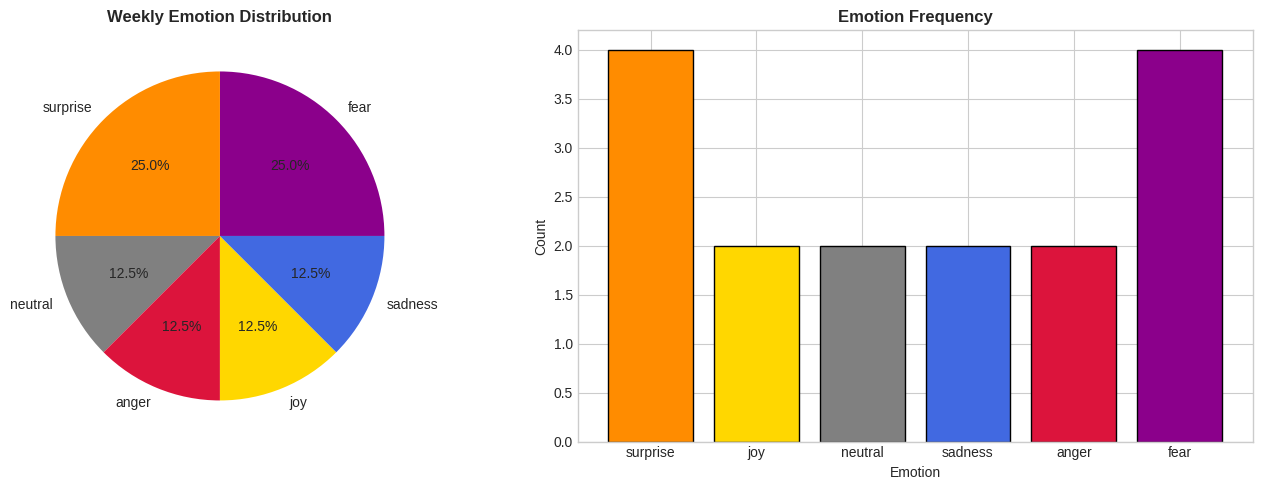

In [9]:
def get_emotion_emoji(emotion):
    return {"joy": "😊", "sadness": "😢", "anger": "😠", "fear": "😰", "surprise": "😮", "neutral": "😐"}.get(emotion, "🙂")

def generate_insights(analytics_engine):
    weekly = analytics_engine.get_weekly_summary()
    insights = []

    # Dominant emotion insight
    insights.append({
        "type": "dominant_emotion",
        "title": "Your Primary Emotion",
        "message": f"This week, you've felt {weekly['dominant_emotion']} most often ({weekly['emotion_percentages'].get(weekly['dominant_emotion'], 0)}% of entries).",
        "emoji": get_emotion_emoji(weekly['dominant_emotion'])
    })

    # Mood trend insight
    trend_msgs = {
        "improving": "Great news! Your mood has been improving. 📈",
        "stable": "Your mood has been consistent this week. ➡️",
        "declining": "Things have been harder lately. Remember, support is available. 💙"
    }
    insights.append({
        "type": "mood_trend",
        "title": "Mood Trend",
        "message": trend_msgs.get(weekly['trend'], "Keep journaling!"),
        "trend": weekly['trend']
    })

    # Emotional stability insight
    vol_msgs = {
        "stable": "Your emotions have been quite stable. 🧘",
        "moderate": "You've experienced a healthy range of emotions. 🌈",
        "high": "You've had a wide range of emotions. Consider grounding exercises. 🌊"
    }
    insights.append({
        "type": "emotional_stability",
        "title": "Emotional Stability",
        "message": vol_msgs.get(weekly['volatility_level'], "Keep journaling!"),
        "level": weekly['volatility_level']
    })

    return insights

# Generate insights
weekly_summary = analytics.get_weekly_summary()
insights = generate_insights(analytics)

print("=" * 70)
print("📊 WEEKLY INSIGHTS")
print("=" * 70)
for insight in insights:
    print(f"\n{insight.get('emoji', '📌')} {insight['title']}")
    print(f"   {insight['message']}")

print("\n" + "=" * 70)
print("📈 MOOD SCORING METHODOLOGY")
print("=" * 70)
print(f"   {weekly_summary['mood_methodology']}")
print(f"   Current Mood Score: {weekly_summary['mood_score']} ({weekly_summary['mood_label']})")

# Visualizations
plt.style.use('seaborn-v0_8-whitegrid')
colors = {"joy": "#FFD700", "sadness": "#4169E1", "anger": "#DC143C", "fear": "#8B008B", "surprise": "#FF8C00", "neutral": "#808080"}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie Chart
emotions = list(weekly_summary["emotion_counts"].keys())
counts = list(weekly_summary["emotion_counts"].values())
non_zero = [(e, c) for e, c in zip(emotions, counts) if c > 0]
if non_zero:
    e_list, c_list = zip(*non_zero)
    axes[0].pie(c_list, labels=e_list, autopct='%1.1f%%', colors=[colors.get(e, "#808080") for e in e_list])
    axes[0].set_title('Weekly Emotion Distribution', fontweight='bold')

# Bar Chart
all_emotions = list(EMOTION_LABELS.values())
all_counts = [weekly_summary["emotion_counts"].get(e, 0) for e in all_emotions]
axes[1].bar(all_emotions, all_counts, color=[colors.get(e, "#808080") for e in all_emotions], edgecolor='black')
axes[1].set_title('Emotion Frequency', fontweight='bold')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**DASHBOARD-READY JSON OUTPUT**

In [10]:
dashboard_data = {
    "generated_at": datetime.now().isoformat(),
    "weekly_summary": weekly_summary,
    "insights": insights,
    "emotion_labels": list(EMOTION_LABELS.values()),
    "mood_scoring_methodology": "Valence values adapted from psychological emotion valence theory (positive vs negative affect scale) and normalized to -1 to +1 range for computational analysis.",
    "chart_data": {
        "emotion_distribution": weekly_summary["emotion_counts"],
        "mood_score": weekly_summary["mood_score"],
        "trend": weekly_summary["trend"]
    }
}

print("=" * 70)
print("📊 DASHBOARD JSON OUTPUT")
print("=" * 70)
print(json.dumps(dashboard_data, indent=2, default=str))

📊 DASHBOARD JSON OUTPUT
{
  "generated_at": "2026-02-04T10:32:31.072405",
  "weekly_summary": {
    "period": {
      "start": "2026-01-28",
      "end": "2026-02-03"
    },
    "total_entries": 16,
    "emotion_counts": {
      "fear": 4,
      "surprise": 4,
      "neutral": 2,
      "anger": 2,
      "joy": 2,
      "sadness": 2
    },
    "emotion_percentages": {
      "fear": 25.0,
      "surprise": 25.0,
      "neutral": 12.5,
      "anger": 12.5,
      "joy": 12.5,
      "sadness": 12.5
    },
    "dominant_emotion": "fear",
    "mood_score": -0.212,
    "mood_label": "neutral",
    "mood_methodology": "Valence values adapted from psychological emotion valence theory (positive vs negative affect scale)",
    "volatility": 0.69,
    "volatility_level": "high",
    "trend": "declining"
  },
  "insights": [
    {
      "type": "dominant_emotion",
      "title": "Your Primary Emotion",
      "message": "This week, you've felt fear most often (25.0% of entries).",
      "emoji": "\ud

**EXPORT ALL DELIVERABLES**

In [11]:
from google.colab import files

# Create output directory
os.makedirs("output", exist_ok=True)

# 1. Save Prompt Templates
with open("output/prompt_templates.json", "w") as f:
    json.dump(PROMPT_TEMPLATES, f, indent=2)
print("✅ Saved: prompt_templates.json")

# 2. Save Safety Guidelines (SEPARATE FILE)
with open("output/safety_guidelines.json", "w") as f:
    json.dump(SAFETY_GUIDELINES, f, indent=2)
print("✅ Saved: safety_guidelines.json")

# 3. Save Dashboard Data
with open("output/dashboard_data.json", "w") as f:
    json.dump(dashboard_data, f, indent=2, default=str)
print("✅ Saved: dashboard_data.json")

# 4. Save Weekly Summary - ONLY ANALYTICS DATA (NOT SAFETY POLICY)
weekly_summary_analytics = {
    "period": weekly_summary["period"],
    "total_entries": weekly_summary["total_entries"],
    "emotion_counts": weekly_summary["emotion_counts"],
    "emotion_percentages": weekly_summary["emotion_percentages"],
    "dominant_emotion": weekly_summary["dominant_emotion"],
    "mood_score": weekly_summary["mood_score"],
    "mood_label": weekly_summary["mood_label"],
    "mood_methodology": "Valence values adapted from psychological emotion valence theory (positive vs negative affect scale) and normalized to -1 to +1 range for computational analysis.",
    "volatility": weekly_summary["volatility"],
    "volatility_level": weekly_summary["volatility_level"],
    "trend": weekly_summary["trend"]
}

with open("output/weekly_summary.json", "w") as f:
    json.dump(weekly_summary_analytics, f, indent=2)
print("✅ Saved: weekly_summary.json")

# 5. Save Insights
with open("output/insights.json", "w") as f:
    json.dump(insights, f, indent=2)
print("✅ Saved: insights.json")

# 6. Save charts
fig.savefig("output/emotion_charts.png", dpi=150, bbox_inches='tight')
print("✅ Saved: emotion_charts.png")

# Verify weekly_summary.json content
print("\n" + "=" * 70)
print("📊 VERIFYING weekly_summary.json (Analytics Data Only):")
print("=" * 70)
with open("output/weekly_summary.json", "r") as f:
    print(json.dumps(json.load(f), indent=2))

print("\n✅ All files saved to 'output/' folder:")
!ls -la output/

# Create ZIP for download
shutil.make_archive("mental_health_ai_output", 'zip', "output")

print("\n📥 Downloading ZIP file...")
files.download("mental_health_ai_output.zip")

print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    ✅ ALL DELIVERABLES COMPLETE!                     ║
╠══════════════════════════════════════════════════════════════════════╣
║  📁 prompt_templates.json     - Emotion-aware response templates     ║
║  📁 safety_guidelines.json    - AI safety guardrails + PK helplines  ║
║  📁 dashboard_data.json       - Complete analytics data              ║
║  📁 weekly_summary.json       - Weekly emotion summary (analytics)   ║
║  📁 insights.json             - Auto-generated insights              ║
║  📁 emotion_charts.png        - Visualization charts                 ║
╚══════════════════════════════════════════════════════════════════════╝
""")

✅ Saved: prompt_templates.json
✅ Saved: safety_guidelines.json
✅ Saved: dashboard_data.json
✅ Saved: weekly_summary.json
✅ Saved: insights.json
✅ Saved: emotion_charts.png

📊 VERIFYING weekly_summary.json (Analytics Data Only):
{
  "period": {
    "start": "2026-01-28",
    "end": "2026-02-03"
  },
  "total_entries": 16,
  "emotion_counts": {
    "fear": 4,
    "surprise": 4,
    "neutral": 2,
    "anger": 2,
    "joy": 2,
    "sadness": 2
  },
  "emotion_percentages": {
    "fear": 25.0,
    "surprise": 25.0,
    "neutral": 12.5,
    "anger": 12.5,
    "joy": 12.5,
    "sadness": 12.5
  },
  "dominant_emotion": "fear",
  "mood_score": -0.212,
  "mood_label": "neutral",
  "mood_methodology": "Valence values adapted from psychological emotion valence theory (positive vs negative affect scale) and normalized to -1 to +1 range for computational analysis.",
  "volatility": 0.69,
  "volatility_level": "high",
  "trend": "declining"
}

✅ All files saved to 'output/' folder:
total 100
drwxr-x

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


╔══════════════════════════════════════════════════════════════════════╗
║                    ✅ ALL DELIVERABLES COMPLETE!                     ║
╠══════════════════════════════════════════════════════════════════════╣
║  📁 prompt_templates.json     - Emotion-aware response templates     ║
║  📁 safety_guidelines.json    - AI safety guardrails + PK helplines  ║
║  📁 dashboard_data.json       - Complete analytics data              ║
║  📁 weekly_summary.json       - Weekly emotion summary (analytics)   ║
║  📁 insights.json             - Auto-generated insights              ║
║  📁 emotion_charts.png        - Visualization charts                 ║
╚══════════════════════════════════════════════════════════════════════╝

